In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
from tqdm import tqdm

In [3]:
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
from sklearn import cluster
from sklearn.model_selection import train_test_split

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory.


In [6]:
root_dir = 'P1_Facial_Keypoints/data/training/'

In [7]:
all_img_paths=glob.glob(os.path.join(root_dir, '*.jpg'))

In [8]:
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [9]:
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [10]:
class FacesData(Dataset):
    def __init__(self, df):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.244, 0.255]
        )
    
    def __len__(self): return len(self.df)

    def __getitem__(self, ix):
        img_path = root_dir + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    
    def preprocess_input(self, img):
        img = cv2.resize(img, (244,244))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    
    def load_img(self, ix):
        img_path = root_dir + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224, 224))
        return img

In [24]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [25]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

In [26]:
model, criterion, optimizer = get_model()

In [27]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [28]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [29]:
train_loss, test_loss = [], []
n_epochs = 50

In [30]:
for epoch in tqdm(range(n_epochs)):
    print(f"epoch {epoch + 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)
    
    for ix, (img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1 : 50


  2%|▏         | 1/50 [00:46<38:18, 46.90s/it]

epoch 2 : 50


  4%|▍         | 2/50 [01:29<35:37, 44.53s/it]

epoch 3 : 50


  6%|▌         | 3/50 [02:16<35:33, 45.39s/it]

epoch 4 : 50


  8%|▊         | 4/50 [03:03<35:20, 46.10s/it]

epoch 5 : 50


 10%|█         | 5/50 [03:47<34:00, 45.35s/it]

epoch 6 : 50


 12%|█▏        | 6/50 [04:29<32:32, 44.38s/it]

epoch 7 : 50


 14%|█▍        | 7/50 [05:12<31:18, 43.67s/it]

epoch 8 : 50


 16%|█▌        | 8/50 [05:55<30:32, 43.62s/it]

epoch 9 : 50


 18%|█▊        | 9/50 [06:41<30:18, 44.35s/it]

epoch 10 : 50


 20%|██        | 10/50 [07:27<29:48, 44.72s/it]

epoch 11 : 50


 22%|██▏       | 11/50 [08:15<29:52, 45.95s/it]

epoch 12 : 50


 24%|██▍       | 12/50 [08:57<28:12, 44.55s/it]

epoch 13 : 50


 26%|██▌       | 13/50 [09:37<26:42, 43.31s/it]

epoch 14 : 50


 28%|██▊       | 14/50 [10:19<25:43, 42.87s/it]

epoch 15 : 50


 30%|███       | 15/50 [11:01<24:48, 42.54s/it]

epoch 16 : 50


 32%|███▏      | 16/50 [11:43<24:03, 42.46s/it]

epoch 17 : 50


 34%|███▍      | 17/50 [12:29<23:58, 43.59s/it]

epoch 18 : 50


 36%|███▌      | 18/50 [13:12<23:04, 43.26s/it]

epoch 19 : 50


 38%|███▊      | 19/50 [13:56<22:26, 43.42s/it]

epoch 20 : 50


 40%|████      | 20/50 [14:37<21:26, 42.88s/it]

epoch 21 : 50


 42%|████▏     | 21/50 [15:19<20:33, 42.52s/it]

epoch 22 : 50


 44%|████▍     | 22/50 [16:02<19:52, 42.59s/it]

epoch 23 : 50


 46%|████▌     | 23/50 [16:44<19:10, 42.61s/it]

epoch 24 : 50


 48%|████▊     | 24/50 [17:28<18:36, 42.93s/it]

epoch 25 : 50


 50%|█████     | 25/50 [18:12<17:58, 43.14s/it]

epoch 26 : 50


 52%|█████▏    | 26/50 [18:57<17:29, 43.73s/it]

epoch 27 : 50


 54%|█████▍    | 27/50 [19:43<17:00, 44.39s/it]

epoch 28 : 50


 56%|█████▌    | 28/50 [20:26<16:11, 44.17s/it]

epoch 29 : 50


 58%|█████▊    | 29/50 [21:08<15:12, 43.48s/it]

epoch 30 : 50


 60%|██████    | 30/50 [21:50<14:21, 43.08s/it]

epoch 31 : 50


 62%|██████▏   | 31/50 [22:33<13:33, 42.83s/it]

epoch 32 : 50


 64%|██████▍   | 32/50 [23:14<12:44, 42.46s/it]

epoch 33 : 50


 66%|██████▌   | 33/50 [23:56<11:59, 42.34s/it]

epoch 34 : 50


 68%|██████▊   | 34/50 [24:37<11:11, 42.00s/it]

epoch 35 : 50


 70%|███████   | 35/50 [25:19<10:29, 41.95s/it]

epoch 36 : 50


 72%|███████▏  | 36/50 [26:04<09:57, 42.68s/it]

epoch 37 : 50


 74%|███████▍  | 37/50 [26:49<09:23, 43.37s/it]

epoch 38 : 50


 76%|███████▌  | 38/50 [27:34<08:46, 43.90s/it]

epoch 39 : 50


 78%|███████▊  | 39/50 [28:20<08:10, 44.56s/it]

epoch 40 : 50


 80%|████████  | 40/50 [28:57<07:02, 42.28s/it]

epoch 41 : 50


 82%|████████▏ | 41/50 [29:36<06:12, 41.34s/it]

epoch 42 : 50


 84%|████████▍ | 42/50 [30:12<05:18, 39.76s/it]

epoch 43 : 50


 86%|████████▌ | 43/50 [30:51<04:35, 39.39s/it]

epoch 44 : 50


 88%|████████▊ | 44/50 [31:29<03:53, 38.97s/it]

epoch 45 : 50


 90%|█████████ | 45/50 [32:06<03:12, 38.56s/it]

epoch 46 : 50


 92%|█████████▏| 46/50 [32:43<02:32, 38.06s/it]

epoch 47 : 50


 94%|█████████▍| 47/50 [33:21<01:54, 38.00s/it]

epoch 48 : 50


 96%|█████████▌| 48/50 [34:02<01:17, 38.99s/it]

epoch 49 : 50


 98%|█████████▊| 49/50 [34:42<00:39, 39.29s/it]

epoch 50 : 50


100%|██████████| 50/50 [35:22<00:00, 42.45s/it]


In [32]:
torch.save(model.state_dict(), 'model/m50e.pt')
#model.load_state_dict(torch.load('/Users/vanka/Documents/learn/pytorch-mini-study/facial-key-point-detect/model/m50e.pt'))

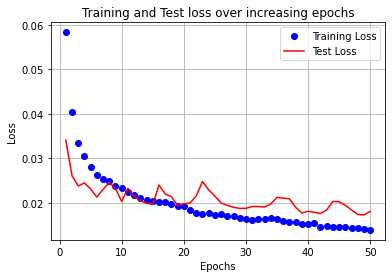

In [ ]:
epochs = np.arange(50)+1
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

## Testing our model

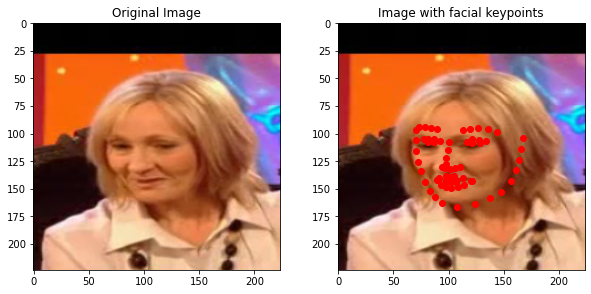

In [ ]:
ix = 0
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Original Image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title("Image with facial keypoints")
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()